# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

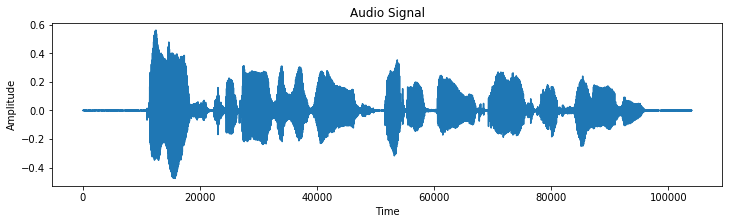

**Shape of Audio Signal** : (103966,)

**Transcript** : the last two days of the voyage bartley found almost intolerable

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

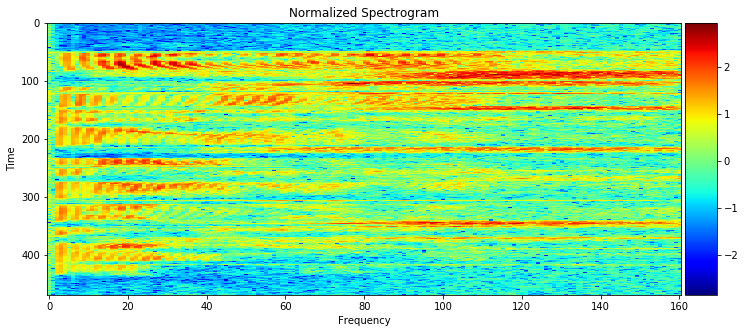

**Shape of Spectrogram** : (470, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

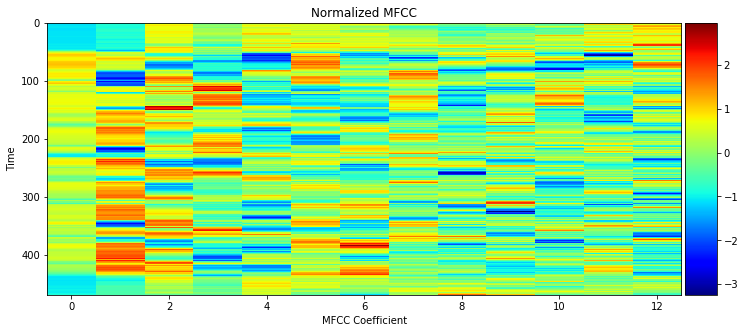

**Shape of MFCC** : (470, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8 # default: 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [27]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [28]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 218s - loss: 844.0349 - val_loss: 728.4707
Epoch 2/20
106/106 [==============================] - 218s - loss: 752.6287 - val_loss: 729.3655
Epoch 3/20
106/106 [==============================] - 218s - loss: 751.4261 - val_loss: 733.6127
Epoch 4/20
106/106 [==============================] - 218s - loss: 751.8330 - val_loss: 725.8642
Epoch 5/20
106/106 [==============================] - 219s - loss: 752.0303 - val_loss: 726.1429
Epoch 6/20
106/106 [==============================] - 217s - loss: 752.3356 - val_loss: 718.0988
Epoch 7/20
106/106 [==============================] - 218s - loss: 752.4947 - val_loss: 735.5372
Epoch 8/20
106/106 [==============================] - 216s - loss: 750.9244 - val_loss: 722.5683
Epoch 9/20
106/106 [==============================] - 218s - loss: 751.4335 - val_loss: 721.2607
Epoch 10/20
106/106 [==============================] - 219s - loss: 751.9498 - val_loss: 729.6367
Epoch 11/20
106/106 [========

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [2]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 219s - loss: 339.4982 - val_loss: 264.8829
Epoch 2/20
106/106 [==============================] - 223s - loss: 229.7115 - val_loss: 241.5117
Epoch 3/20
106/106 [==============================] - 223s - loss: 198.6244 - val_loss: 202.6635
Epoch 4/20
106/106 [==============================] - 219s - loss: 178.7576 - val_loss: 173.1604
Epoch 5/20
106/106 [==============================] - 218s - loss: 164.7513 - val_loss: 167.9364
Epoch 6/20
106/106 [==============================] - 218s - loss: 156.8874 - val_loss: 155.4971
Epoch 7/20
106/106 [==============================] - 219s - loss: 150.8683 - val_loss: 154.5558
Epoch 8/20
106/106 [==============================] - 217s - loss: 147.3927 - val_loss: 149.3976
Epoch 9/20
106/106 [==============================] - 219s - loss: 145.4073 - val_loss: 156.9566
Epoch 10/20
106/106 [==============================] - 219s - loss: 142.1694 - val_loss: 151.6462
Epoch 11/20
106/106 [========

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [25]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11,
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         354400    
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [26]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 117s - loss: 240.1008 - val_loss: 236.6273
Epoch 2/20
106/106 [==============================] - 114s - loss: 178.4964 - val_loss: 167.2338
Epoch 3/20
106/106 [==============================] - 114s - loss: 152.2920 - val_loss: 145.5248
Epoch 4/20
106/106 [==============================] - 114s - loss: 138.6954 - val_loss: 143.6604
Epoch 5/20
106/106 [==============================] - 114s - loss: 128.7395 - val_loss: 136.9678
Epoch 6/20
106/106 [==============================] - 113s - loss: 121.3800 - val_loss: 133.6874
Epoch 7/20
106/106 [==============================] - 114s - loss: 114.9541 - val_loss: 130.2283
Epoch 8/20
106/106 [==============================] - 113s - loss: 108.8656 - val_loss: 130.1771
Epoch 9/20
106/106 [==============================] - 114s - loss: 104.1560 - val_loss: 128.6848
Epoch 10/20
106/106 [==============================] - 113s - loss: 99.8767 - val_loss: 127.0333
Epoch 11/20
106/106 [=========

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [21]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn0 (GRU)                   (None, None, 200)         217200    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [22]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 363s - loss: 281.1128 - val_loss: 242.1370
Epoch 2/20
106/106 [==============================] - 367s - loss: 221.2522 - val_loss: 214.0980
Epoch 3/20
106/106 [==============================] - 367s - loss: 198.3634 - val_loss: 183.6138
Epoch 4/20
106/106 [==============================] - 367s - loss: 165.0478 - val_loss: 159.6835
Epoch 5/20
106/106 [==============================] - 364s - loss: 148.1717 - val_loss: 151.3065
Epoch 6/20
106/106 [==============================] - 368s - loss: 138.5968 - val_loss: 142.4858
Epoch 7/20
106/106 [==============================] - 367s - loss: 132.1400 - val_loss: 141.0833
Epoch 8/20
106/106 [==============================] - 364s - loss: 128.4057 - val_loss: 136.4292
Epoch 9/20
106/106 [==============================] - 364s - loss: 124.8896 - val_loss: 135.6408
Epoch 10/20
106/106 [==============================] - 366s - loss: 123.1076 - val_loss: 133.3129
Epoch 11/20
106/106 [========

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [23]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidir_rnn (Bidirectional)    (None, None, 400)         434400    
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [24]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 333s - loss: 280.8536 - val_loss: 225.1232
Epoch 2/20
106/106 [==============================] - 337s - loss: 228.7989 - val_loss: 214.9556
Epoch 3/20
106/106 [==============================] - 337s - loss: 209.7339 - val_loss: 190.2173
Epoch 4/20
106/106 [==============================] - 339s - loss: 187.5988 - val_loss: 176.3730
Epoch 5/20
106/106 [==============================] - 339s - loss: 172.8992 - val_loss: 164.5834
Epoch 6/20
106/106 [==============================] - 339s - loss: 160.7087 - val_loss: 155.0573
Epoch 7/20
106/106 [==============================] - 338s - loss: 152.0099 - val_loss: 148.4835
Epoch 8/20
106/106 [==============================] - 339s - loss: 145.3564 - val_loss: 144.2322
Epoch 9/20
106/106 [==============================] - 338s - loss: 139.6844 - val_loss: 140.7401
Epoch 10/20
106/106 [==============================] - 339s - loss: 134.5383 - val_loss: 139.7370
Epoch 11/20
106/106 [========

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [ ]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

#### Model 5: model_2 + MFCC_13 features

In [13]:
model_5 = cnn_rnn_model(input_dim=13, 
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         28800     
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [28]:
train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5',
            spectrogram=False, # change to False if you would like to use MFCC features
            epochs=20)

Epoch 1/20
106/106 [==============================] - 150s - loss: 232.6412 - val_loss: 232.6524
Epoch 2/20
106/106 [==============================] - 146s - loss: 170.4899 - val_loss: 154.7021
Epoch 3/20
106/106 [==============================] - 145s - loss: 146.2117 - val_loss: 140.1627
Epoch 4/20
106/106 [==============================] - 146s - loss: 133.2318 - val_loss: 137.9232
Epoch 5/20
106/106 [==============================] - 147s - loss: 124.8521 - val_loss: 131.7379
Epoch 6/20
106/106 [==============================] - 145s - loss: 117.8514 - val_loss: 127.0911
Epoch 7/20
106/106 [==============================] - 147s - loss: 112.0849 - val_loss: 126.4759
Epoch 8/20
106/106 [==============================] - 145s - loss: 107.3329 - val_loss: 125.1087
Epoch 9/20
106/106 [==============================] - 145s - loss: 103.2267 - val_loss: 120.5914
Epoch 10/20
106/106 [==============================] - 146s - loss: 99.4264 - val_loss: 123.1785
Epoch 11/20
106/106 [=========

#### Model 6: model_2 + MFCC_13 features

In [29]:
model_6 = cnn_rnn_model(input_dim=13, 
                        filters=200,
                        kernel_size=4, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         10600     
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [30]:
train_model(input_to_softmax=model_6, 
            pickle_path='model_6.pickle', 
            save_model_path='model_6.h5',
            spectrogram=False, # change to False if you would like to use MFCC features
            epochs=20)

Epoch 1/20
106/106 [==============================] - 151s - loss: 239.1198 - val_loss: 231.2787
Epoch 2/20
106/106 [==============================] - 147s - loss: 182.3953 - val_loss: 170.9214
Epoch 3/20
106/106 [==============================] - 146s - loss: 156.7609 - val_loss: 157.3926
Epoch 4/20
106/106 [==============================] - 146s - loss: 140.7371 - val_loss: 139.7314
Epoch 5/20
106/106 [==============================] - 146s - loss: 130.9164 - val_loss: 133.3606
Epoch 6/20
106/106 [==============================] - 146s - loss: 123.4645 - val_loss: 131.4643
Epoch 7/20
106/106 [==============================] - 147s - loss: 117.5992 - val_loss: 129.0966
Epoch 8/20
106/106 [==============================] - 147s - loss: 113.0486 - val_loss: 124.1567
Epoch 9/20
106/106 [==============================] - 148s - loss: 108.8941 - val_loss: 125.4353
Epoch 10/20
106/106 [==============================] - 145s - loss: 104.9292 - val_loss: 124.9548
Epoch 11/20
106/106 [========

#### Model 7: model_2 + MFCC_13 features'

In [2]:
model_7 = cnn_rnn_model(input_dim=13, 
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=40)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         28800     
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 40)          28920     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 40)          160       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          1189      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [3]:
train_model(input_to_softmax=model_7, 
            pickle_path='model_7.pickle', 
            save_model_path='model_7.h5',
            spectrogram=False, # change to False if you would like to use MFCC features
            epochs=20)

Epoch 1/20
106/106 [==============================] - 171s - loss: 241.8146 - val_loss: 199.6075
Epoch 2/20
106/106 [==============================] - 149s - loss: 189.4670 - val_loss: 173.6689
Epoch 3/20
106/106 [==============================] - 149s - loss: 165.1364 - val_loss: 160.1651
Epoch 4/20
106/106 [==============================] - 148s - loss: 153.7501 - val_loss: 151.7198
Epoch 5/20
106/106 [==============================] - 148s - loss: 146.7991 - val_loss: 146.5976
Epoch 6/20
106/106 [==============================] - 151s - loss: 141.7324 - val_loss: 145.3141
Epoch 7/20
106/106 [==============================] - 150s - loss: 138.3010 - val_loss: 143.8021
Epoch 8/20
106/106 [==============================] - 149s - loss: 135.5032 - val_loss: 140.4520
Epoch 9/20
106/106 [==============================] - 148s - loss: 132.6696 - val_loss: 139.9600
Epoch 10/20
106/106 [==============================] - 149s - loss: 130.8905 - val_loss: 137.7157
Epoch 11/20
106/106 [========

#### Model 8: model_3 + MFCC_13 features

In [31]:
model_8 = deep_rnn_model(input_dim=13, 
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn0 (GRU)                   (None, None, 200)         128400    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [32]:
train_model(input_to_softmax=model_8, 
            pickle_path='model_8.pickle', 
            save_model_path='model_8.h5',
            spectrogram=False, # change to False if you would like to use MFCC features
            epochs=20)

Epoch 1/20
106/106 [==============================] - 396s - loss: 268.8579 - val_loss: 307.7577
Epoch 2/20
106/106 [==============================] - 397s - loss: 219.4083 - val_loss: 274.0636
Epoch 3/20
106/106 [==============================] - 396s - loss: 188.8539 - val_loss: 197.4051
Epoch 4/20
106/106 [==============================] - 397s - loss: 166.1568 - val_loss: 159.4167
Epoch 5/20
106/106 [==============================] - 394s - loss: 151.7725 - val_loss: 148.2725
Epoch 6/20
106/106 [==============================] - 395s - loss: 142.5945 - val_loss: 143.3108
Epoch 7/20
106/106 [==============================] - 395s - loss: 134.9933 - val_loss: 138.3974
Epoch 8/20
106/106 [==============================] - 396s - loss: 129.3505 - val_loss: 135.1663
Epoch 9/20
106/106 [==============================] - 394s - loss: 124.7150 - val_loss: 134.7165
Epoch 10/20
106/106 [==============================] - 395s - loss: 120.5616 - val_loss: 132.4129
Epoch 11/20
106/106 [========

#### Model 9: model_4 + MFCC_13 features

In [33]:
model_9 = bidirectional_rnn_model(input_dim=13, 
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidir_rnn (Bidirectional)    (None, None, 400)         256800    
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 268,429
Trainable params: 268,429
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
train_model(input_to_softmax=model_9, 
            pickle_path='model_9.pickle', 
            save_model_path='model_9.h5',
            spectrogram=False, # change to False if you would like to use MFCC features
            epochs=20)

Epoch 1/20
106/106 [==============================] - 361s - loss: 297.6789 - val_loss: 207.2687
Epoch 2/20
106/106 [==============================] - 363s - loss: 206.7690 - val_loss: 189.2544
Epoch 3/20
106/106 [==============================] - 363s - loss: 193.0224 - val_loss: 180.7370
Epoch 4/20
106/106 [==============================] - 364s - loss: 181.7896 - val_loss: 168.6648
Epoch 5/20
106/106 [==============================] - 362s - loss: 171.7714 - val_loss: 161.6785
Epoch 6/20
106/106 [==============================] - 363s - loss: 162.6059 - val_loss: 157.1273
Epoch 7/20
106/106 [==============================] - 361s - loss: 153.7990 - val_loss: 149.3015
Epoch 8/20
106/106 [==============================] - 363s - loss: 145.5042 - val_loss: 141.5891
Epoch 9/20
106/106 [==============================] - 363s - loss: 138.6174 - val_loss: 139.0852
Epoch 10/20
106/106 [==============================] - 362s - loss: 132.7331 - val_loss: 134.3965
Epoch 11/20
106/106 [========

#### Model 10: model_2 with dropout and MFCC features

In [35]:
# from sample_models import custom_model_0

model_10 = custom_model_0(input_dim=13, # change to 13 if you would like to use MFCC features
                          filters=200,
                          kernel_size=11, 
                          conv_stride=2,
                          conv_border_mode='valid',
                          units=200,
                          rate=0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         28800     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
gru_7 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
__________

In [36]:
train_model(input_to_softmax=model_10, 
           pickle_path='model_10.pickle',
           save_model_path='model_10.h5',
           spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 149s - loss: 244.4869 - val_loss: 227.4482
Epoch 2/20
106/106 [==============================] - 147s - loss: 187.1054 - val_loss: 165.2577
Epoch 3/20
106/106 [==============================] - 146s - loss: 164.9628 - val_loss: 146.6593
Epoch 4/20
106/106 [==============================] - 147s - loss: 152.7289 - val_loss: 137.4656
Epoch 5/20
106/106 [==============================] - 143s - loss: 144.3904 - val_loss: 133.7415
Epoch 6/20
106/106 [==============================] - 144s - loss: 138.0385 - val_loss: 130.2174
Epoch 7/20
106/106 [==============================] - 145s - loss: 132.6859 - val_loss: 124.7202
Epoch 8/20
106/106 [==============================] - 146s - loss: 128.9295 - val_loss: 123.7744
Epoch 9/20
106/106 [==============================] - 145s - loss: 125.5645 - val_loss: 120.4490
Epoch 10/20
106/106 [==============================] - 146s - loss: 122.1725 - val_loss: 119.2608
Epoch 11/20
106/106 [========

#### Model 11: model_2 with dilated convolutions and MFCC features

In [37]:
from sample_models import custom_model_1

model_11 = custom_model_1(input_dim=13, # change to 13 if you would like to use MFCC features
                          filters=200,
                          kernel_size=11, 
                          conv_stride=1,
                          conv_border_mode='valid',
                          units=200,
                          dilation=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
dcnn (Conv1D)                (None, None, 200)         28800     
_________________________________________________________________
bn_dcnn (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [38]:
train_model(input_to_softmax=model_11, 
           pickle_path='model_11.pickle',
           save_model_path='model_11.h5',
           spectrogram=False, # change to False if you would like to use MFCC features
           epochs=20) 

Epoch 1/20
106/106 [==============================] - 197s - loss: 255.2131 - val_loss: 242.0214
Epoch 2/20
106/106 [==============================] - 197s - loss: 227.5424 - val_loss: 216.4676
Epoch 3/20
106/106 [==============================] - 196s - loss: 221.1868 - val_loss: 205.8527
Epoch 4/20
106/106 [==============================] - 191s - loss: nan - val_loss: nan
Epoch 5/20
106/106 [==============================] - 188s - loss: nan - val_loss: nan
Epoch 6/20
106/106 [==============================] - 187s - loss: nan - val_loss: nan
Epoch 7/20
106/106 [==============================] - 188s - loss: nan - val_loss: nan
Epoch 8/20
106/106 [==============================] - 188s - loss: nan - val_loss: nan
Epoch 9/20
106/106 [==============================] - 188s - loss: nan - val_loss: nan
Epoch 10/20
106/106 [==============================] - 187s - loss: nan - val_loss: nan
Epoch 11/20
106/106 [==============================] - 187s - loss: nan - val_loss: nan
Epoch 12/20

#### Model 12: model_2 with max_pooling and MFCC features

In [6]:
from sample_models import custom_model_2

model_12 = custom_model_2(input_dim=13, # change to 13 if you would like to use MFCC features
                          filters=200,
                          kernel_size=11, 
                          conv_stride=2,
                          conv_border_mode='valid',
                          units=80,
                          dilation=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         28800     
_________________________________________________________________
max_pool (MaxPooling1D)      (None, None, 200)         0         
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 80)          67440     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 80)          320       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          2349      
__________

In [7]:
train_model(input_to_softmax=model_12, 
           pickle_path='model_12.pickle',
           save_model_path='model_12.h5',
           spectrogram=False, # change to False if you would like to use MFCC features
           epochs=20) 

Epoch 1/20
106/106 [==============================] - 120s - loss: 212.1737 - val_loss: 191.4800
Epoch 2/20
106/106 [==============================] - 105s - loss: 181.8434 - val_loss: 168.3923
Epoch 3/20
106/106 [==============================] - 104s - loss: 167.8539 - val_loss: 164.1095
Epoch 4/20
106/106 [==============================] - 103s - loss: 160.6319 - val_loss: 159.6125
Epoch 5/20
106/106 [==============================] - 104s - loss: 155.4993 - val_loss: 157.0046
Epoch 6/20
106/106 [==============================] - 104s - loss: 150.8785 - val_loss: 154.1146
Epoch 7/20
106/106 [==============================] - 104s - loss: 147.2351 - val_loss: 152.3384
Epoch 8/20
106/106 [==============================] - 103s - loss: 144.5730 - val_loss: 152.2902
Epoch 9/20
106/106 [==============================] - 103s - loss: 142.2535 - val_loss: 152.2169
Epoch 10/20
106/106 [==============================] - 104s - loss: 139.5956 - val_loss: 152.3619
Epoch 11/20
106/106 [========

#### Model 13: model_4 as deep_bidir_rnn

In [17]:
from sample_models import custom_model_3

model_13 = custom_model_3(input_dim=13, # change to 13 if you would like to use MFCC features
                          units=200,
                          recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidir_rnn0 (Bidirectional)   (None, None, 400)         256800    
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 400)         721200    
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 989,629
Trainable params: 989,629
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
train_model(input_to_softmax=model_13, 
           pickle_path='model_13.pickle',
           save_model_path='model_13.h5',
           spectrogram=False, # change to False if you would like to use MFCC features
           epochs=20) 

Epoch 1/20
106/106 [==============================] - 623s - loss: 282.7529 - val_loss: 224.1764
Epoch 2/20
106/106 [==============================] - 623s - loss: 222.2848 - val_loss: 201.2693
Epoch 3/20
106/106 [==============================] - 622s - loss: 198.3698 - val_loss: 180.5717
Epoch 4/20
106/106 [==============================] - 620s - loss: 180.1644 - val_loss: 165.2312
Epoch 5/20
106/106 [==============================] - 624s - loss: 162.1147 - val_loss: 150.1941
Epoch 6/20
106/106 [==============================] - 623s - loss: 147.2851 - val_loss: 140.6936
Epoch 7/20
106/106 [==============================] - 625s - loss: 136.4283 - val_loss: 132.0660
Epoch 8/20
106/106 [==============================] - 624s - loss: 128.0427 - val_loss: 125.1716
Epoch 9/20
106/106 [==============================] - 624s - loss: 121.0095 - val_loss: 122.2163
Epoch 10/20
106/106 [==============================] - 626s - loss: 115.0628 - val_loss: 120.9758
Epoch 11/20
106/106 [========

#### Model 14: model_2 with dropout and MFCC_13 features 

In [19]:
model_14 = custom_model_0(input_dim=13, # change to 13 if you would like to use MFCC features
                          filters=200, # default is 200
                          kernel_size=3, #default is 11
                          conv_stride=2,
                          conv_border_mode='same',
                          units=200,
                          rate=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         8000      
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
gru_9 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
__________

In [20]:
train_model(input_to_softmax=model_14, 
           pickle_path='model_14.pickle',
           save_model_path='model_14.h5',
           spectrogram=False, # change to False if you would like to use MFCC features
           epochs=20) 

Epoch 1/20
106/106 [==============================] - 148s - loss: 253.1063 - val_loss: 244.3133
Epoch 2/20
106/106 [==============================] - 144s - loss: 211.4553 - val_loss: 186.6763
Epoch 3/20
106/106 [==============================] - 148s - loss: 192.1527 - val_loss: 168.8785
Epoch 4/20
106/106 [==============================] - 145s - loss: 179.2446 - val_loss: 153.2085
Epoch 5/20
106/106 [==============================] - 146s - loss: 170.9202 - val_loss: 148.7339
Epoch 6/20
106/106 [==============================] - 145s - loss: 164.2880 - val_loss: 140.0823
Epoch 7/20
106/106 [==============================] - 145s - loss: 159.2505 - val_loss: 137.6919
Epoch 8/20
106/106 [==============================] - 147s - loss: 155.9386 - val_loss: 135.0354
Epoch 9/20
106/106 [==============================] - 147s - loss: 152.3984 - val_loss: 132.8112
Epoch 10/20
106/106 [==============================] - 147s - loss: 149.1234 - val_loss: 130.5486
Epoch 11/20
106/106 [========

#### Model 15: model_2 with dropout and MFCC_13 features

In [21]:
model_15 = custom_model_0(input_dim=13, # change to 13 if you would like to use MFCC features
                          filters=200, # default is 200
                          kernel_size=11, #default is 11
                          conv_stride=2,
                          conv_border_mode='valid',
                          units=200,
                          rate=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         28800     
_________________________________________________________________
dropout_19 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
gru_10 (GRU)                 (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          5829      
__________

In [22]:
train_model(input_to_softmax=model_15, 
           pickle_path='model_15.pickle',
           save_model_path='model_15.h5',
           spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 150s - loss: 252.3775 - val_loss: 225.7536
Epoch 2/20
106/106 [==============================] - 146s - loss: 204.8480 - val_loss: 177.3161
Epoch 3/20
106/106 [==============================] - 147s - loss: 184.4140 - val_loss: 158.6509
Epoch 4/20
106/106 [==============================] - 146s - loss: 172.4329 - val_loss: 144.2617
Epoch 5/20
106/106 [==============================] - 146s - loss: 163.7039 - val_loss: 141.1059
Epoch 6/20
106/106 [==============================] - 147s - loss: 157.2157 - val_loss: 135.0004
Epoch 7/20
106/106 [==============================] - 146s - loss: 152.6520 - val_loss: 130.7171
Epoch 8/20
106/106 [==============================] - 146s - loss: 148.4688 - val_loss: 128.9524
Epoch 9/20
106/106 [==============================] - 145s - loss: 145.0161 - val_loss: 124.7606
Epoch 10/20
106/106 [==============================] - 145s - loss: 142.0896 - val_loss: 124.6921
Epoch 11/20
106/106 [========

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

All Models: 



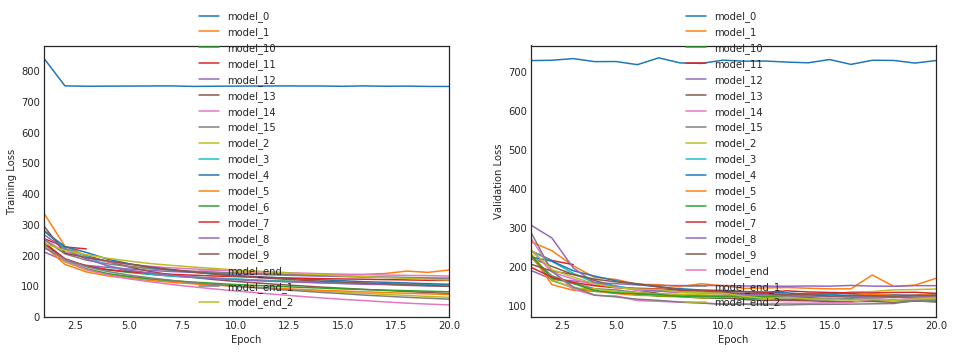

In [39]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))

##################################################################
#************************ All Models ****************************#
##################################################################
print ('All Models: \n')
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

Standard Models: 



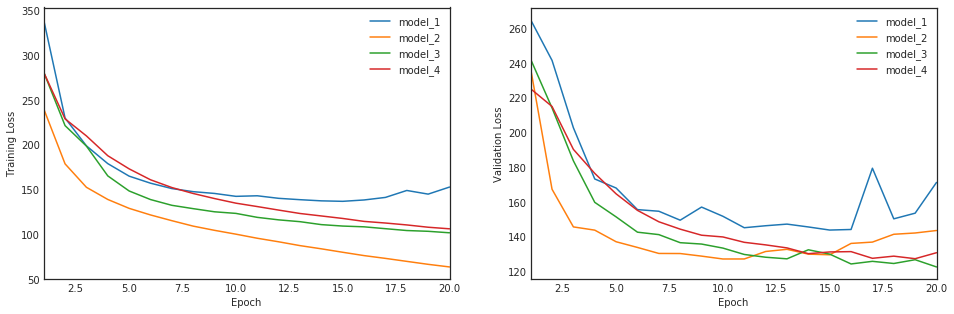

In [40]:
##################################################################
#************************* Models 1-4 ***************************#
##################################################################
print ('Standard Models: \n')
# extract the name of each model
model_names = [item[8:-7] for item in (all_pickles[1], all_pickles[8], all_pickles[9], all_pickles[10])]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in (all_pickles[1], all_pickles[8], all_pickles[9], all_pickles[10])]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in (all_pickles[1], all_pickles[8], all_pickles[9], all_pickles[10])]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len((all_pickles[1], all_pickles[8], all_pickles[9], all_pickles[10]))):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len((all_pickles[1], all_pickles[8], all_pickles[9], all_pickles[10]))):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

Relevant Models: 



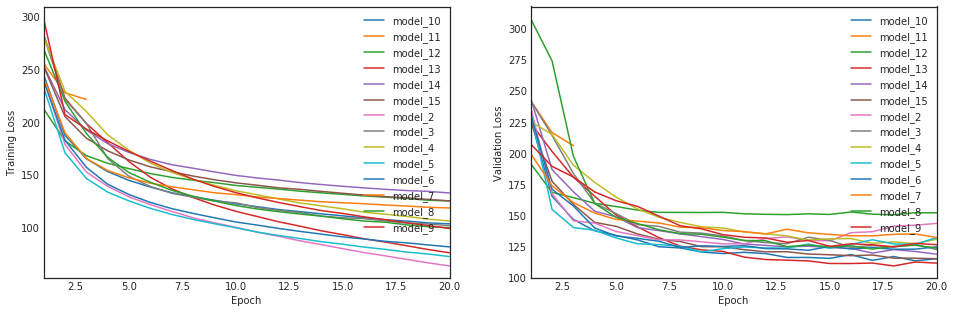

In [41]:
##################################################################
#********************** Relevant Models *************************#
##################################################################
print ('Relevant Models: \n')
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles[2:16]]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles[2:16]]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles[2:16]]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles[2:16])):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles[2:16])):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

Custom Models: 



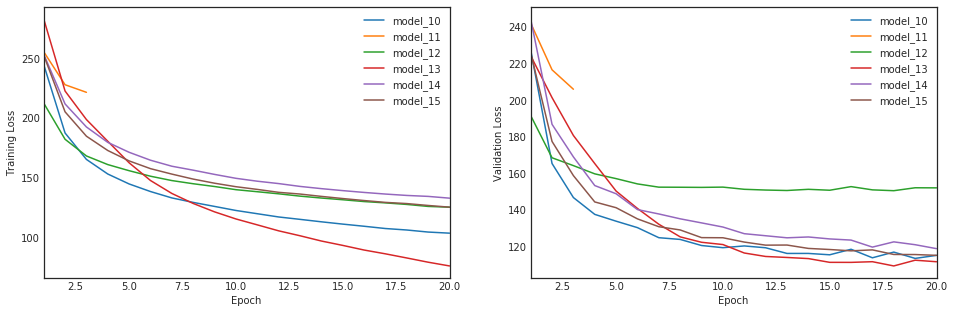

In [42]:
##################################################################
#*********************** Custom Models **************************#
##################################################################
print ('Custom Models: \n')
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles[2:8]]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles[2:8]]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles[2:8]]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles[2:8])):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles[2:8])):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

Selected Models I: 



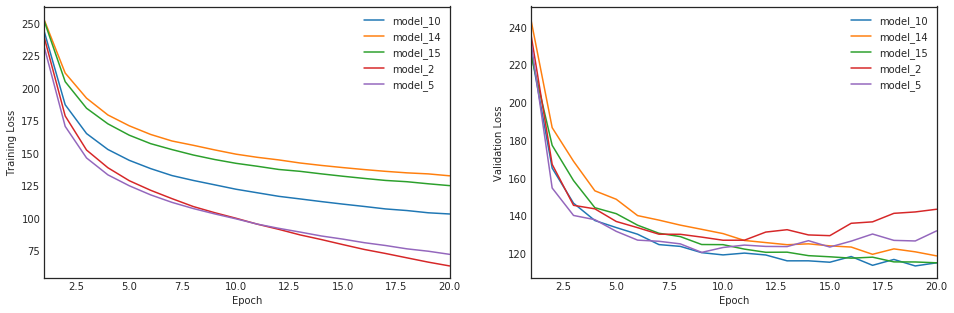

In [43]:
##################################################################
#********************** Selected Models *************************#
##################################################################
print ('Selected Models I: \n')
# extract the name of each model
model_names = [item[8:-7] for item in (all_pickles[2], all_pickles[6], all_pickles[7], all_pickles[8], all_pickles[11])]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in (all_pickles[2], all_pickles[6], all_pickles[7], all_pickles[8], all_pickles[11])]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in (all_pickles[2], all_pickles[6], all_pickles[7], all_pickles[8], all_pickles[11])]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len((all_pickles[2], all_pickles[6], all_pickles[7], all_pickles[8], all_pickles[11]))):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len((all_pickles[2], all_pickles[6], all_pickles[7], all_pickles[8], all_pickles[11]))):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

Selected Models II: 



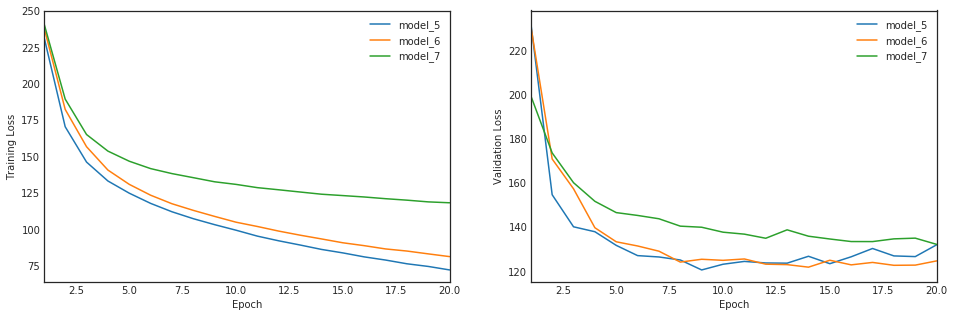

In [44]:
##################################################################
#********************** Selected Models *************************#
##################################################################
print ('Selected Models II: \n')
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles[11:14]]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles[11:14]]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles[11:14]]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles[11:14])):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles[11:14])):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

Selected Models III: 



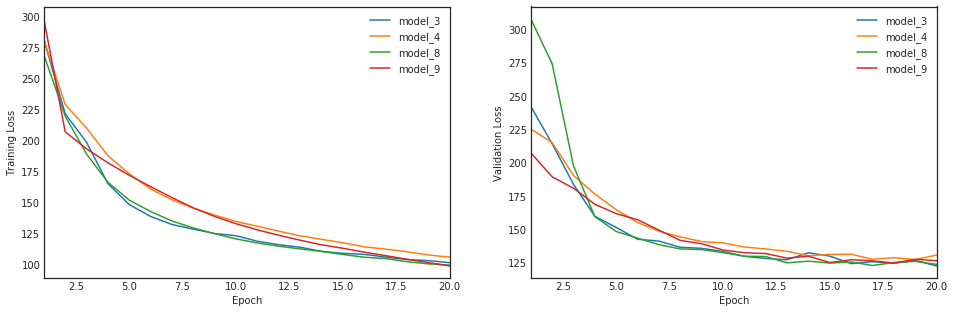

In [45]:
##################################################################
#********************** Selected Models *************************#
##################################################################
print ('Selected Models III: \n')
# extract the name of each model
model_names = [item[8:-7] for item in (all_pickles[9], all_pickles[10], all_pickles[14], all_pickles[15])]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in (all_pickles[9], all_pickles[10], all_pickles[14], all_pickles[15])]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in (all_pickles[9], all_pickles[10], all_pickles[14], all_pickles[15])]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len((all_pickles[9], all_pickles[10], all_pickles[14], all_pickles[15]))):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len((all_pickles[9], all_pickles[10], all_pickles[14], all_pickles[15]))):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

1. In general MFCC features as input (e.g. model_5, model_8-9) seem to perform slightly better than the more complex spectrograms (model_2, model_3-4).
2. Regarding the given standard models (model_0-4), the cnn (model_2) "memorized" the data faster than the other models because it adds a lot of complexity to the computing model. The downside of "memorizing" quickly on small data is the tendency of overfitting after a few epochs. 
3. Using MFCC features (model_5), adding dropout (model_10, model_14-15) and adjusting the hyperparameters (model_6-7, model_14) helped to improve the outcome of the cnn (model_2) 
4. A simple rnn (model_0) gives not enough complexity to the model, to master the challenge of speech recognition. 
5. A timedistributed dense layer (model_1) helped to improve the simple rnn to form a more complex model and performed much better because of the time-dependend data. 
6. Regarding training loss both deep-rnns (model_3) and bidirectional rnns (model_4) didn't perform as well as the cnn did, but had a better outcome regarding validation loss, because these architectures help in identifying more generalized corelations. 
7. Max pooling (model_12) doesn't work, because too much information gets lost. 
8. Dilated cnns (model_11) should perform better than default cnns. To achieve that additional adjustments have to be made. 
9. Deep bidrectional rnns (model_13) increase the complexity of the model a lot and also help to generalize correlations. They performed a lot better than most of the models and should be considered as essential parts of every acoustic model. 

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [47]:
# specify the model I:
model_end = final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=4, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=300,
                        dropout=0.03)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         10600     
_________________________________________________________________
dropout_27 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 300)         450900    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 300)         1200      
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 600)         1081800   
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [48]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            epochs=20) # TODO: increase epochs for final model!!!

Epoch 1/20
106/106 [==============================] - 519s - loss: 233.5105 - val_loss: 275.4066
Epoch 2/20
106/106 [==============================] - 521s - loss: 182.1697 - val_loss: 190.4410
Epoch 3/20
106/106 [==============================] - 523s - loss: 154.0786 - val_loss: 142.6556
Epoch 4/20
106/106 [==============================] - 526s - loss: 136.4371 - val_loss: 127.1726
Epoch 5/20
106/106 [==============================] - 520s - loss: 123.5747 - val_loss: 125.5486
Epoch 6/20
106/106 [==============================] - 524s - loss: 113.9077 - val_loss: 113.7910
Epoch 7/20
106/106 [==============================] - 523s - loss: 104.9392 - val_loss: 111.8671
Epoch 8/20
106/106 [==============================] - 520s - loss: 97.4693 - val_loss: 109.4228
Epoch 9/20
106/106 [==============================] - 522s - loss: 90.5099 - val_loss: 107.6556
Epoch 10/20
106/106 [==============================] - 521s - loss: 83.9649 - val_loss: 104.3131
Epoch 11/20
106/106 [===========

In [18]:
# specify the model II:
model_end = final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=4, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=300,
                        dropout=0.07)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         10600     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 300)         450900    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 300)         1200      
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 600)         1081800   
__________

In [19]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end_1.pickle', 
            save_model_path='model_end_1.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            epochs=20) # TODO: increase epochs for final model!!!

Epoch 1/20
106/106 [==============================] - 517s - loss: 225.6498 - val_loss: 290.4856
Epoch 2/20
106/106 [==============================] - 517s - loss: 188.5924 - val_loss: 188.7392
Epoch 3/20
106/106 [==============================] - 520s - loss: 163.0939 - val_loss: 148.7881
Epoch 4/20
106/106 [==============================] - 518s - loss: 147.4324 - val_loss: 127.9280
Epoch 5/20
106/106 [==============================] - 517s - loss: 135.7341 - val_loss: 123.1994
Epoch 6/20
106/106 [==============================] - 518s - loss: 126.5824 - val_loss: 117.4243
Epoch 7/20
106/106 [==============================] - 515s - loss: 118.6177 - val_loss: 114.3636
Epoch 8/20
106/106 [==============================] - 517s - loss: 111.1907 - val_loss: 110.3441
Epoch 9/20
106/106 [==============================] - 519s - loss: 105.3693 - val_loss: 107.5517
Epoch 10/20
106/106 [==============================] - 516s - loss: 99.1966 - val_loss: 104.4768
Epoch 11/20
106/106 [=========

In [34]:
# specify the model III:
model_end = final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=4, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=300,
                        dropout=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         10600     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 300)         450900    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 300)         1200      
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 600)         1081800   
__________

In [35]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end_2.pickle', 
            save_model_path='model_end_2.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            epochs=20) # TODO: increase epochs for final model!!!

Epoch 1/20
106/106 [==============================] - 511s - loss: 239.9061 - val_loss: 245.4502
Epoch 2/20
106/106 [==============================] - 520s - loss: 216.2639 - val_loss: 192.9840
Epoch 3/20
106/106 [==============================] - 515s - loss: 202.5033 - val_loss: 174.0043
Epoch 4/20
106/106 [==============================] - 515s - loss: 190.5995 - val_loss: 156.7050
Epoch 5/20
106/106 [==============================] - 516s - loss: 181.5105 - val_loss: 147.3565
Epoch 6/20
106/106 [==============================] - 520s - loss: 173.3477 - val_loss: 142.9877
Epoch 7/20
106/106 [==============================] - 516s - loss: 167.3545 - val_loss: 142.4097
Epoch 8/20
106/106 [==============================] - 514s - loss: 162.0418 - val_loss: 135.2563
Epoch 9/20
106/106 [==============================] - 515s - loss: 157.4004 - val_loss: 133.7446
Epoch 10/20
106/106 [==============================] - 518s - loss: 152.4954 - val_loss: 132.6207
Epoch 11/20
106/106 [========

Final Model: 



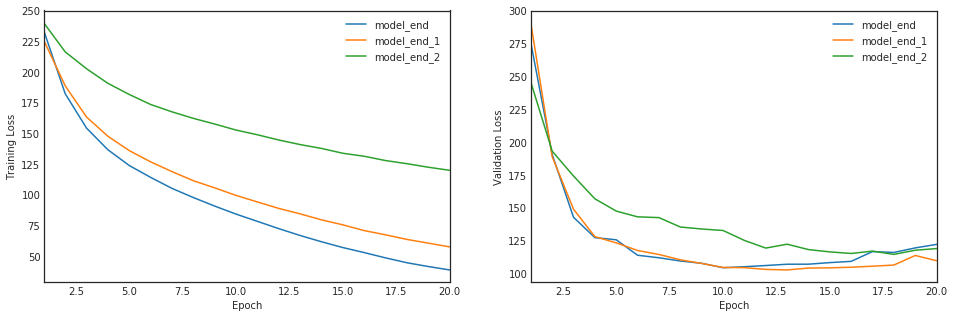

In [46]:
##################################################################
#************************ Final Model ***************************#
##################################################################
print ('Final Model: \n')
# extract the name of each model
model_names = [item[8:-7] for item in (all_pickles[16:19])]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in (all_pickles[16:19])]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in (all_pickles[16:19])]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len((all_pickles[16:19]))):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len((all_pickles[16:19]))):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

1. MFCC features help to reduce the complexity of the input data, even though MFCC with input_dim=39 may probably even better.
2. The cnn (1 layer) / rnn (1 layer) layers help to reduce training time without sacrificing complexity.
3. The deep bidirectional rnn (2 layers) improves model complexity and help identifying more general correlations. 
4. Dropout layers (3 layers, + intergrated dropout in the rnn) prevent overfitting. Dropout rate of 0.07 (model_end_1) was the best amongst the 3 trained models with the given amount of epochs. A value of 0.10-0.13 might improve the result. 
5. The timedistributed layer (1 layer) gives the model a sense for time related correlations.
6. This model would profit a lot more on bigger data and additional epochs with the right choice of hyperparameters.

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [36]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=False) # change to False if you would like to use MFCC features
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [37]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=4, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=300,
                        dropout=0.07), model_path='results/model_end_1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         10600     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 300)         450900    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 300)         1200      
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 600)         1081800   
__________

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [38]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=4, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=300,
                        dropout=0.07),  
                model_path='results/model_end_1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 200)         10600     
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 300)         450900    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 300)         1200      
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 600)         1081800   
__________

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!

## OPTIONAL STEPS
#### Add a language model

In [ ]:
from collections import Counter
import numpy as np
# import utils

# Part 1 - Extract tokens and bigrams from a sentence
# Part 2 - Calculate probabilities for bigrams
# Part 3 - Calculate the log probability of a given sentence based on a corpus of text using bigrams

test_sentences = [
    'the old man spoke to me',
    'me to spoke man old the',
    'old man me old man me',
]

# utils.py:
# Part 1 - Extract tokens and bigrams from a sentence
# creates a list of tokens and a list of bigrams for a given sentence 
def sentence_to_bigrams(sentence):
    """
    Add start '<s>' and stop '</s>' tags to the sentence and tokenize it into a list
    of lower-case words (sentence_tokens) and bigrams (sentence_bigrams)
    :param sentence: string
    :return: list, list
        sentence_tokens: ordered list of words found in the sentence
        sentence_bigrams: a list of ordered two-word tuples found in the sentence
    """
    sentence_tokens = ['<s>'] + sentence.lower().split() + ['</s>']
    sentence_bigrams = []
    for i in range(len(sentence_tokens)-1):
        sentence_bigrams.append((sentence_tokens[i], sentence_tokens[i+1]))
    return sentence_tokens, sentence_bigrams


# Part 2 - Calculate probabilities for bigrams
def bigrams_from_transcript(filename):
    """
    read a file of sentences, adding start '<s>' and stop '</s>' tags; Tokenize it into a list of lower case words
    and bigrams
    :param filename: string 
        filename: path to a text file consisting of lines of non-puncuated text; assume one sentence per line
    :return: list, list
        tokens: ordered list of words found in the file
        bigrams: a list of ordered two-word tuples found in the file
    """
    tokens = []
    bigrams = []
    with open(filename, 'r') as f:
        for line in f:
            line_tokens, line_bigrams = sentence_to_bigrams(line)
            tokens = tokens + line_tokens
            bigrams = bigrams + line_bigrams
    return tokens, bigrams


# Part 2 - Calculate probabilities for bigrams
def bigram_mle(tokens, bigrams):
    """
    provide a dictionary of probabilities for all bigrams in a corpus of text
    the calculation is based on maximum likelihood estimation and does not include
    any smoothing.  A tag '<unk>' has been added for unknown probabilities.
    :param tokens: list
        tokens: list of all tokens in the corpus
    :param bigrams: list
        bigrams: list of all two word tuples in the corpus
    :return: dict
        bg_mle_dict: a dictionary of bigrams:
            key: tuple of two bigram words, in order OR <unk> key
            value: float probability

    """
    bg_mle_dict = {}
    bg_mle_dict['<unk>'] = 0.
    token_raw_counts = Counter(tokens)
    bigram_raw_counts = Counter(bigrams)
    for bg in bigram_raw_counts:
        bg_mle_dict[bg] = bigram_raw_counts[bg] / token_raw_counts[bg[0]]
    return bg_mle_dict


# Part 3 - Calculate the log probability of a given sentence based on a corpus of text using bigrams
def bigram_add1_logs(transcript_file):
    """
    provide a smoothed log probability dictionary based on a transcript
    :param transcript_file: string
        transcript_file is the path filename containing unpunctuated text sentences
    :return: dict
        bg_add1_log_dict: dictionary of smoothed bigrams log probabilities including
        tags: <s>: start of sentence, </s>: end of sentence, <unk>: unknown placeholder probability
    """

    tokens, bigrams = bigrams_from_transcript(transcript_file)
    token_counts = Counter(tokens)
    bigram_counts = Counter(bigrams)
    vocab_count = len(token_counts)

    bg_addone_dict = {}
    for bg in bigram_counts:
        bg_addone_dict[bg] = np.log((bigram_counts[bg] + 1.) / (token_counts[bg[0]] + vocab_count))
    bg_addone_dict['<unk>'] = np.log(1. / vocab_count)
    return bg_addone_dict


# Part 3 - Calculate the log probability of a given sentence based on a corpus of text using bigrams
def log_prob_of_sentence(sentence, bigram_log_dict):
    total_log_prob = 0.
    # get the sentence bigrams with utils.sentence_to_bigrams
    # look up the bigrams from the sentence in the bigram_log_dict
    # add all the the log probabilities together
    # if a word doesn't exist, be sure to use the value of the '<unk>' lookup instead
    
    # get the sentence bigrams
    s_tokens, s_bigrams = sentence_to_bigrams(sentence)
    
    # add the log probabilites of the bigrams in the sentence
    total_log_prob = 0.
    for bg in s_bigrams:
        if bg in bigram_log_dict:
            total_log_prob = total_log_prob + bigram_log_dict[bg]
        else:
            total_log_prob = total_log_prob + bigram_log_dict['<unk>']
    return total_log_prob

# Part 2
def sample_run():
    # sample usage by test code (this definition not actually run for the quiz)
    tokens, bigrams = bigrams_from_transcript('transcripts.txt') # TODO: read all the transcript files available 
    bg_dict = bigram_mle(tokens, bigrams)
    print(bg_dict)

# Part 3
def sample_run():
    # sample usage by test code (this definition not actually run for the quiz)
    bigram_log_dict = bigram_add1_logs('transcripts.txt') # TODO: read all the transcript files available
    for sentence in test_sentences: # TODO: use any given sentence from get_predictions
        print('*** "{}"'.format(sentence))
        print(log_prob_of_sentence(sentence, bigram_log_dict))
        
# TODO: Create actual language model interface to the output of the acoustic model

# ************* #
# TODO: n-grams #  
# ************* #



#### Try different audio features

In [8]:
# TODO: try different audio features
""" 
# MFCC-39 features

# use http://python-speech-features.readthedocs.io/en/latest/
"""

#### Train on bigger data set

In [ ]:
# TODO: train on bigger data set
"""
# train-clean-100.tar.gz [6.3G]   (training set of 100 hours "clean" speech ) 
# train-clean-360.tar.gz [23G]   (training set of 360 hours "clean" speech ) 
# train-other-500.tar.gz [30G]   (training set of 500 hours "other" speech ) 

# Step 1: Download the appropriate subsets of the LibriSpeech dataset, and convert all flac files to wav format.

wget http://www.openslr.org/resources/12/dev-clean.tar.gz
tar -xzvf dev-clean.tar.gz
wget http://www.openslr.org/resources/12/test-clean.tar.gz
tar -xzvf test-clean.tar.gz
mv flac_to_wav.sh LibriSpeech
cd LibriSpeech
./flac_to_wav.sh

# Step 2: Create JSON files corresponding to the train and validation datasets.

cd ..
python create_desc_json.py LibriSpeech/dev-clean/ train_corpus.json
python create_desc_json.py LibriSpeech/test-clean/ valid_corpus.json

# Step 3: Train the model!
"""

#### Train on augmented and/or alterated data for more data/better robustness

In [9]:
# TODO: creatre augmented data

# TODO: create alterated data with noise

#### Add a third bidirectional layer to the model

In [ ]:
# TODO: add a third bidirectional layer, increase dropout and epochs

#### Finetuning of hyperparameters and model architecture

In [ ]:
# TODO: a lot... :) 